<a href="https://colab.research.google.com/github/swapnilmn/Assignment_1-CS6910/blob/master/Question_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries 

In [1]:
from keras.datasets import fashion_mnist, mnist
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
from sklearn.model_selection import train_test_split 
import pickle
import pandas as pd
import os
from tqdm import tqdm_notebook 
from sklearn.preprocessing import OneHotEncoder

In [4]:
!pip install wandb
import wandb
wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=618300696a2e66ea3f9fee61978a8c03c1dd3a7d3b9e7cf237571431cd3320a5
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Data Processing

In [2]:

class OneHotEncoder_from_scratch:
    
    def __init__(self):
        self.categories = None
    def fit(self, X):
        self.categories =[]
        for i in range(X.shape[1]):
            feature_categories =list(set(X[:, i]))
            self.categories.append(feature_categories)
            
    def transform(self, X):
        one_hot_vector = []

        for i in range(X.shape[0]):
            one_hot_row = []
            for j in range(X.shape[1]):

                category_index = self.categories[j].index(X[i, j])
                category_one_hot =[0] *len(self.categories[j])
                category_one_hot[category_index] = 1

                one_hot_row.extend(category_one_hot)
            one_hot_vector.append(one_hot_row)
        return np.array(one_hot_vector)

In [3]:

dataset = 'fashion_mnist'
if dataset == 'fashion_mnist':
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
elif dataset == 'mnist':
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
else:
    raise ValueError('Invalid dataset name')
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)
train_input = []
for i in range(len(X_train)):
    train_input.append(list(np.concatenate(X_train[i]).flat))

val_input = []
for i in range(len(X_val)):
    val_input.append(list(np.concatenate(X_val[i]).flat))

test_input = []
for i in range(len(test_images)):
    test_input.append(list(np.concatenate(test_images[i]).flat))
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(test_labels)

X_train = np.array(train_input) / 255.0
X_test = np.array(test_input) / 255.0
X_val = np.array(val_input) / 255.0

enc = OneHotEncoder_from_scratch()
enc.fit(Y_train.reshape(-1, 1))
Y_train = enc.transform(Y_train.reshape(-1, 1))
Y_val = enc.transform(Y_val.reshape(-1, 1))
Y_test = enc.transform(Y_test.reshape(-1, 1))

print(Y_train.shape, Y_val.shape, Y_test.shape)
print(X_train.shape, X_val.shape, X_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(54000, 10) (6000, 10) (10000, 10)
(54000, 784) (6000, 784) (10000, 784)


# Class of FeedForward Neural Network

wandb: Currently logged in as: ed22s009. Use `wandb login --relogin` to force relogin


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch: 10, Train Loss: 0.11813202728773542, Train Accuracy: 0.5774444444444444, Val Loss: 0.1193877588397095, Val Accuracy: 0.5631666666666667
Model trained successfully !
[[441  24 133  15  38   1 308   0  40   0]
 [ 43 885  25  15   5   0  22   0   5   0]
 [  4   1 920   0  32   0   8   0  35   0]
 [102 220  96 320 188   0  60   0  14   0]
 [  3  10 798   6 153   0   9   0  21   0]
 [  0   0   7   2   0 186   1 331 297 176]
 [ 83  10 639   5  51   0 148   0  64   0]
 [  0   0   0   0   0  14   0 901  39  46]
 [  1   4  38   2   2   0   0   6 947   0]
 [  1   0  16   1   0  14   0 148  56 764]]


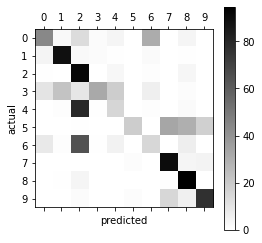

In [5]:
wandb.init(project = 'Question_3')
class FFNetwork:
  def __init__(self, X, Y,
               epochs = 100, 
               hidden_layer_count = 4,
               hidden_layers =  [32, 64, 128, 256],
               learning_rate = 0.001,
               batch_size = 32,
               activation='tanh',
               weight_init='random',
               loss = 'MSE',
               weight_decay = 0):
    
    self.inputs =X.shape[1] # Number of inputs
    self.outputs= Y.shape[1] # Number of outputs
    self.epochs = epochs
    self.hidden_layers = hidden_layer_count  # Number of hidden layers 
    self.network_size= [self.inputs] + hidden_layers +[self.outputs] # input layer + hidden layers + output layers
    self.learning_rate = learning_rate
    self.batch_size = batch_size
    self.weights={} # It will create dictionary for weights and biases
    self.weights_h = []
    self.num_classes = Y.shape[1]
    self.weight_init = weight_init
    self.activation_function = activation
    self.loss_function = loss
    self.lambd = 0
    np.random.seed(0)  # We will set seed value so that it will generate same random numebers every time

    self.grad_derivatice={}
    self.update_weights={}
    self.prev_update_weights={}
    for i in range(1,self.hidden_layers+1):
      self.update_weights['vw'+str(i)]=0
      self.update_weights['vb'+str(i)]=0
      self.update_weights['mb'+str(i)]=0
      self.update_weights['mw'+str(i)]=0
      self.prev_update_weights['vw'+str(i)]=0
      self.prev_update_weights['vb'+str(i)]=0
    
    if self.weight_init == 'random':
      for i in range(1,self.hidden_layers+2):
        self.weights['W'+str(i)] = np.random.randn(self.network_size[i-1],self.network_size[i])*0.1
        self.weights['B'+str(i)] = np.zeros((1,self.network_size[i]))
    
    elif self.weight_init == 'Xavier':
      for i in range(1,self.hidden_layers+2):
        self.weights['W'+str(i)]=np.random.randn(self.network_size[i-1],self.network_size[i])*np.sqrt(1/self.network_size[i-1])
        self.weights['B'+str(i)] = np.zeros((1,self.network_size[i]))

  
  def forward_activation(self, X): 
    if self.activation_function == 'sigmoid':
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == 'tanh':
      return np.tanh(X)
    elif self.activation_function == 'Relu':
      return np.maximum(0,X)

  def grad_activation(self, X):
    if self.activation_function == 'sigmoid':
      return X*(1-X) 
    elif self.activation_function == 'tanh':
      return (1-np.square(X))
    elif self.activation_function == 'Relu':
      return 1.0*(X>0)

  def softmax(self, X):
    exps =np.exp(X - np.max(X, axis=1, keepdims=True))
    return  exps /np.sum(exps, axis=1, keepdims=True)
  
  def forward_pass(self,X, weights=None):
    if weights is None:
        weights = self.weights
    self.A ={}
    self.H ={}
    self.H[0] = X
    for i in range(self.hidden_layers):
        self.A[i+1] =np.matmul(self.H[i], weights[f'W{i+1}']) + weights[f'B{i+1}']
        self.H[i+1] = self.forward_activation(self.A[i+1])
    self.A[self.hidden_layers+1] = np.matmul(self.H[self.hidden_layers],weights[f'W{self.hidden_layers+1}']) +weights[f'B{self.hidden_layers+1}']
    self.H[self.hidden_layers+1] =self.softmax(self.A[self.hidden_layers+1])
    return self.H[self.hidden_layers+1]
  
  def backprop(self, X, Y, weights=None):
    if weights is None:
        weights = self.weights

    self.forward_pass(X, weights)
    self.grad_derivatice = {}
    L = self.hidden_layers + 1

    if self.loss_function == 'CE':
        self.grad_derivatice[f'dA{L}'] = (self.H[L] - Y) * (1/X.shape[0])
    elif self.loss_function == 'MSE':
        self.grad_derivatice[f'dA{L}'] = (1/X.shape[0]) * 2 * (self.H[L] - Y)

    for k in range(L, 0, -1):
        self.grad_derivatice[f'dW{k}'] = np.matmul(self.H[k-1].T, self.grad_derivatice[f'dA{k}']) + self.lambd * weights[f'W{k}']
        self.grad_derivatice[f'dB{k}'] = np.sum(self.grad_derivatice[f'dA{k}'], axis=0).reshape(1, -1)
        self.grad_derivatice[f'dH{k-1}'] = np.matmul(self.grad_derivatice[f'dA{k}'], weights[f'W{k}'].T)
        self.grad_derivatice[f'dA{k-1}'] = np.multiply(self.grad_derivatice[f'dH{k-1}'], self.grad_activation(self.H[k-1]))

    return self.grad_derivatice[f'dH{k-1}']
  
  def fit(self, X, Y, X_val, Y_val,algo= 'GD',a = 10, eps=1e-8, beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9 ):
    
    eta = self.learning_rate
    mini_batch_size = self.batch_size
    epochs = self.epochs
    for num_epoch in tqdm(range(1, epochs+1), unit='epoch'):
      m = X.shape[0]
      
      if algo == 'SGD':
          for i in range(m):
              rand_idx = np.random.randint(m)
              x_i =X[rand_idx:rand_idx+1]
              y_i =  Y[rand_idx:rand_idx+1]
              self.backprop(x_i, y_i)
              for j in range(1, self.hidden_layers+1):
                  self.weights['W' + str(j)] -= eta*(self.grad_derivatice['dW' + str(j)])
                  self.weights['B' + str(j)] -= eta*(self.grad_derivatice['dB' +str(j)])
          self.wandlog(num_epoch, X, Y,  X_val, Y_val)
        
            
      elif algo == 'Momentum':
        self.backprop(X, Y)

        for i in range(1,self.hidden_layers+1):

          self.update_weights['vw'+str(i)] =gamma *self.update_weights['vw'+str(i)] + eta*(self.grad_derivatice['dW'+str(i)])
          self.update_weights['vb'+str(i)] = gamma*self.update_weights['vb'+str(i)] +  eta *(self.grad_derivatice['dB'+str(i)])
          self.weights['W'+str(i)] -=self.update_weights['vw'+str(i)]
          self.weights['B'+str(i)]-= self.update_weights['vb'+str(i)]
        self.wandlog(num_epoch, X, Y,X_val,Y_val)
          
      elif algo == 'NAG':
        temp_weights = {}
        for i in range(1, self.hidden_layers+2):

            temp_weights['W'+str(i)] = np.zeros_like(self.weights['W'+str(i)])
            temp_weights['B'+str(i)] = np.zeros_like(self.weights['B'+str(i)])
        for i in range(1,self.hidden_layers+1):

          self.update_weights['vw'+str(i)]=gamma*self.prev_update_weights['vw'+str(i)]
          self.update_weights['vb'+str(i)]=gamma*self.prev_update_weights['vb'+str(i)]
          temp_weights['W'+str(i)]=self.weights['W'+str(i)]-self.update_weights['vw'+str(i)]
          temp_weights['B'+str(i)]=self.weights['B'+str(i)]-self.update_weights['vb'+str(i)]
        self.backprop(X,Y,temp_weights)

        for i in range(1,self.hidden_layers+1):
          self.update_weights['vw'+str(i)] = gamma*self.update_weights['vw'+str(i)] + eta *(self.grad_derivatice['dW'+str(i)])
          self.update_weights['vb'+str(i)] = gamma *self.update_weights['vb'+str(i)] + eta * ( self.grad_derivatice['dB'+str(i)])
          self.weights['W'+str(i)] -= eta *(self.update_weights['vw'+str(i)])
          self.weights['B'+str(i)]-= eta *(self.update_weights['vb'+str(i)]) 
        self.prev_update_weights=self.update_weights

        self.wandlog(num_epoch, X, Y,X_val, Y_val)

        
      elif algo == 'AdaGrad':
        self.backprop(X, Y)

        for i in range(1,self.hidden_layers+1):
          self.update_weights['vw'+str(i)] += (self.grad_derivatice['dW'+str(i)])**2
          self.update_weights['vb'+str(i)] += (self.grad_derivatice['dB'+str(i)])**2
          self.weights['W'+str(i)] -= (eta/(np.sqrt(self.update_weights['vw'+str(i)])+eps)) *(self.grad_derivatice['dW'+str(i)])
          self.weights['B'+str(i)] -=((eta/(np.sqrt(self.update_weights['vb'+str(i)])+eps))* (self.grad_derivatice['dB'+str(i)]))
        self.wandlog(num_epoch, X, Y,X_val, Y_val)
      
      elif algo == 'RMSProp':
        self.backprop(X, Y)
        for i in range(1,self.hidden_layers+1):
          self.update_weights['vw'+str(i)] = beta*self.update_weights['vw'+str(i)]   +(1-beta)*((self.grad_derivatice['dW'+str(i)])**2)
          self.update_weights['vb'+str(i)] =beta*self.update_weights['vb'+str(i)] +(1-beta)*((self.grad_derivatice['dB'+str(i)])**2)
          self.weights['W'+str(i)] -=(eta/(np.sqrt(self.update_weights['vw'+str(i)]+eps)))*(self.grad_derivatice['dW'+str(i)])
          self.weights['B'+str(i)]-= (eta/(np.sqrt(self.update_weights['vb'+str(i)]+eps)))*(self.grad_derivatice['dB'+str(i)])
        self.wandlog(num_epoch, X, Y,X_val, Y_val)

  def predict(self, X):
    Y_pred = (self.forward_pass(X))
    return np.array(Y_pred).squeeze()
  
  def accuracy_score(self, X, Y):
    Y_true = np.argmax(Y, axis=1).reshape(-1, 1)
    pred_labels = np.argmax(self.predict(X), axis=1).reshape(-1,1)
    return np.sum(pred_labels == Y_true) / len(Y)

  def Loss(self, X, Y):
    Y_pred = self.predict(X)
    if self.loss_function== 'CE':
        loss = -np.mean(Y * np.log(Y_pred + 1e-8))
    elif self.loss_function == 'MSE':
        loss = np.mean((Y - Y_pred)**2)
    return loss

  def performance(self, X_test, Y_test):
    loss = self.Loss(X_test, Y_test)
    accuracy = self.accuracy_score(X_test, Y_test)
    return loss, accuracy


  def confusion_matrix(self, actual_labels, predicted_labels):
    available_classes = np.unique(np.concatenate((actual_labels,predicted_labels)))
    confusion_matrix_ = np.zeros((len(available_classes),len(available_classes)),dtype=int)
    for i,actual in enumerate(available_classes):
        for j,predicted in enumerate(available_classes):
            confusion_matrix_[i,j] = np.where((actual_labels == actual)&(predicted_labels == predicted))[0].shape[0]

    return confusion_matrix_

  def confusion_matrix(self,X, Y):
    actual_labels = pd.Series(np.argmax(Y_test, axis = 1), name='Actual')
    predicted_labels = y_prediction = pd.Series(np.argmax(model.forward_pass(X_test), axis=1), name='Predicted')
    available_classes = np.unique(np.concatenate((actual_labels,predicted_labels)))
    confusion_matrix_ = np.zeros((len(available_classes),len(available_classes)),dtype=int)
    for i,actual in enumerate(available_classes):
        for j,predicted in enumerate(available_classes):
            confusion_matrix_[i,j] = np.where((actual_labels == actual)&(predicted_labels == predicted))[0].shape[0]

    return confusion_matrix_


  def confusion_matrix_plot(self, confusion_matrix, title='Confusion matrix', cmap=plt.cm.gray_r):
    confusion_matrix = confusion_matrix/10
    plt.matshow(confusion_matrix, cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(confusion_matrix))
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    plt.ylabel('actual')
    plt.xlabel('predicted')


  def wandlog(self, num_epoch, X, Y,X_val, Y_val):
    accuracy = self.accuracy_score(X, Y)
    loss_train = self.Loss(X, Y)
    loss_valid = self.Loss(X_val, Y_val)
    val_accuracy = self.accuracy_score(X_val, Y_val)
    wandb.log({'epoch': num_epoch,           
              'loss': loss_train,
              'accuracy': accuracy,
              'val_loss': loss_valid,
              'val_accuracy': val_accuracy})
    
    if num_epoch % 10== 0:
      accuracy = self.accuracy_score(X, Y)
      loss_train = self.Loss(X, Y)
      loss_valid = self.Loss(X_val, Y_val)
      val_accuracy = self.accuracy_score(X_val, Y_val)
      library = {'epoch': num_epoch,           
              'loss': loss_train,
              'accuracy': accuracy,
              'val_loss': loss_valid,
              'val_accuracy': val_accuracy}

      print('Epoch: {}, Train Loss: {}, Train Accuracy: {}, Val Loss: {}, Val Accuracy: {}'.format(library['epoch'], library['loss'], library['accuracy'], library['val_loss'], library['val_accuracy']))
      if num_epoch == self.epochs:
        print('Model trained successfully !')
    
  
model = FFNetwork(X_train, Y_train,
                  epochs = 10, 
                  hidden_layer_count = 4,
                  hidden_layers =  [32, 64, 128, 256],
                  learning_rate = 0.001,
                  batch_size = 32,
                  activation='Relu',
                  weight_init='random',
                  loss = 'CE')
model.fit(X_train, Y_train, X_val, Y_val,algo= 'RMSProp', a = 1)
confusion_matrix = model.confusion_matrix(X_test, Y_test)
print(confusion_matrix)
model.confusion_matrix_plot(confusion_matrix)